### Santiago García - Catalina Guatibonza

# PARCIAL 2 | MÉTODOS COMPUTACIONALES II

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

## Algoritmo Multipaso

In [2]:
def f(x, y):
    return x + 2*y

def RungeKutta4(x, y, h):
    for i in range(1, len(x)):
        k1 = f(x[i-1], y[i-1])
        k2 = f(x[i-1] + 0.5*h, y[i-1] + 0.5*k1*h)
        k3 = f(x[i-1] + 0.5*h, y[i-1] + 0.5*k2*h)
        k4 = f(x[i-1] + h, y[i-1] + k3*h)
        
        y[i] = y[i-1] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    return y

In [3]:
def Bashford(x, y, h):
    for i in range(3, len(x) - 1):
        y[i+1] = y[i] + h*((1901/720)*f(x[i], y[i]) - 
                           (2774/720)*f(x[i-1], y[i-1]) + 
                           (2616/720)*f(x[i-2], y[i-2]) - 
                           (1274/720)*f(x[i-3], y[i-3]) + 
                           (251/720)*f(x[i-4], y[i-4]))
    return y

In [4]:
def Moulton(x, y, h):
    for i in range(3, len(x) - 1):
        y_temp = y[i] + h*((475/1440)*f(x[i+1], y[i+1]) + 
                           (1427/1440)*f(x[i], y[i]) - 
                           (798/1440)*f(x[i-1], y[i-1]) + 
                           (482/1440)*f(x[i-2], y[i-2]) - 
                           (173/1440)*f(x[i-3], y[i-3]) + 
                           (27/1440)*f(x[i-4], y[i-4]))
        
        y[i+1] = y_temp
    return y

In [5]:
def Exacta(x):
    return -0.5*x - (1 - np.exp(2*x)) / 4

In [6]:
x = np.linspace(0, 4, 100)
h = x[1] - x[0]
y = np.zeros_like(x)
y[0] = 0 

In [7]:
y_rk4 = RungeKutta4(x, y, h)
y_predicted = Bashford(x, y_rk4, h)
y_corrected = Moulton(x, y_predicted, h)
y_exact = Exacta(x)

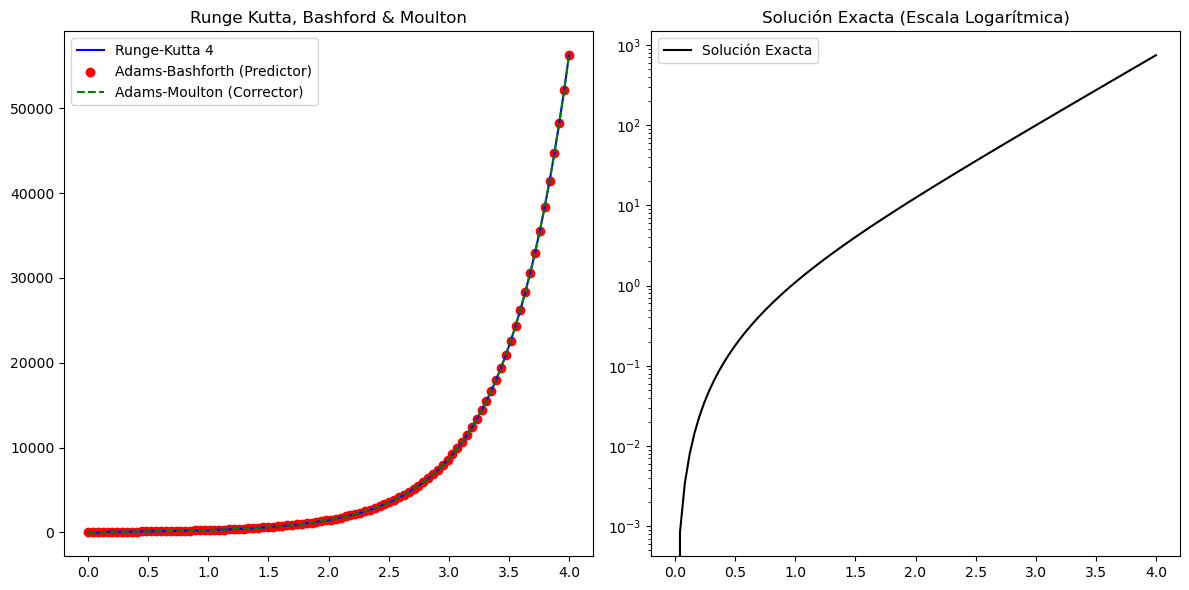

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x, y_rk4, label='Runge-Kutta 4', color='blue')
plt.scatter(x, y_predicted, label='Adams-Bashforth (Predictor)', color='red')
plt.plot(x, y_corrected, label='Adams-Moulton (Corrector)', color='green', linestyle='--')
plt.legend()
plt.title('Runge Kutta, Bashford & Moulton')

plt.subplot(1, 2, 2)
plt.plot(x, y_exact, label='Solución Exacta', color='black', linestyle='-')
plt.yscale('log')
plt.legend()
plt.title('Solución Exacta (Escala Logarítmica)')

plt.tight_layout()
plt.show()

## Particle Decay (Adaptativo) 

In [9]:
def System(r, t):
    NA, NB, NC = r
    lambA = 0.5/h 
    lambB = 0.3/h 

    dNAdt = -lambA * NA
    dNBdt = lambA * NA - lambB * NB
    dNCdt = lambB * NB

    return np.array([dNAdt, dNBdt, dNCdt])

In [10]:
def Increment(f, r, t, h):
    state1 = np.array([r[0], r[1], r[2]])
    K1 = f(state1, t)
    
    state2 = np.array([r[0] + 0.5 * h * K1[0], r[1] + 0.5 * h * K1[1], r[2] + 0.5 * h * K1[2]])
    K2 = f(state2, t + 0.5 * h)
    
    state3 = np.array([r[0] + 0.5 * h * K2[0], r[1] + 0.5 * h * K2[1], r[2] + 0.5 * h * K2[2]])
    K3 = f(state3, t + 0.5 * h)
    
    state4 = np.array([r[0] + h * K3[0], r[1] + h * K3[1], r[2] + h * K3[2]])
    K4 = f(state4, t + h)
    
    Deltaf = h * (K1 + 2 * K2 + 2 * K3 + K4) / 6
    
    return r + Deltaf

In [11]:
def CheckStep(Delta1, Delta2, Delta3, h, minimo=1e-2, maximo=1e-1):
    tolerancia = 0.001
    
    if np.abs(Delta1) < tolerancia:
        h = minimo
        dx = Delta1
    else:
        if np.abs(Delta1 - Delta2) / np.abs(Delta1) > maximo:
            h = 0.5 * h
            dx = Delta2
        elif np.abs(Delta1 - Delta3) / np.abs(Delta1) < minimo:
            h = 2 * h
            dx = Delta3
        else:
            dx = Delta1
    return dx, h

In [19]:
def Adaptativo_fehlberg(f, r0, t0, tf, e=1e-4):
    h = 0.1 
    t = t0

    TimeVector = [t]
    Vectors = [np.array(r0)]

    r = np.array(r0)
    while t < tf:
    
        r1 = Increment(f, r, t, h)
        
        r2 = Increment(f, r1, t + h, h)
        
        rt = Increment(f, r, t, 2*h)
        
        error = np.linalg.norm(r2 - rt)
        
        if error < e:
            t += 2*h
            r = rt
            TimeVector.append(t)
            Vectors.append(r)

        q = 0.85 * (e / error) ** 0.25
        h *= q

        if t + h > tf:
            h = tf - t

    return TimeVector, np.array(Vectors)

In [20]:
r0 = [100, 0, 0]
t0 = 0  
tf = 10 

In [21]:
TimeVector_fehlberg, Vectors_fehlberg = Adaptativo_fehlberg(System, r0, t0, tf)

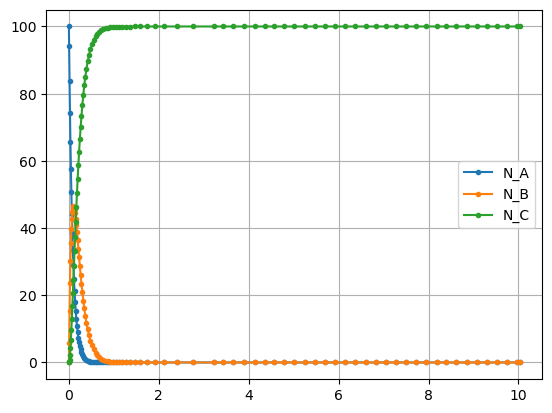

In [22]:
plt.plot(TimeVector_fehlberg, Vectors_fehlberg[:, 0], label='N_A', marker='.')
plt.plot(TimeVector_fehlberg, Vectors_fehlberg[:, 1], label='N_B', marker='.')
plt.plot(TimeVector_fehlberg, Vectors_fehlberg[:, 2], label='N_C', marker='.')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
indice_max_B = np.argmax(Vectors_fehlberg[:, 1])  
momento_max_B = TimeVector_fehlberg[indice_max_B] 
cantidad_max_B = Vectors_fehlberg[indice_max_B, 1] 

In [24]:
cantidad_B_en_momento_max = cantidad_max_B
cantidad_C_en_momento_max = Vectors_fehlberg[indice_max_B, 2]

print(f"(f) En el momento t = {momento_max_B} horas, la cantidad de partículas B es máxima.")
print(f"(g) En ese momento, hay aproximadamente {cantidad_B_en_momento_max:.2f} partículas B y {cantidad_C_en_momento_max:.2f} partículas C.")

(f) En el momento t = 0.10030331262758144 horas, la cantidad de partículas B es máxima.
(g) En ese momento, hay aproximadamente 46.46 partículas B y 24.64 partículas C.
